In [1]:
import tensorflow as tf
import torch
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

print("\n")
if torch.cuda.is_available():
    print("GPU is available.")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

2025-11-01 12:52:42.109321: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.20.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


GPU is available.
Device name: Tesla T4


In [2]:
import numpy as np
import struct
def float32_to_bfloat16_array(x: np.ndarray) -> np.ndarray:
    x = x.astype(np.float32)
    u = x.view(np.uint32)
    top = (u >> 16).astype(np.uint16)
    recon = (top.astype(np.uint32) << 16)
    return recon.view(np.float32)
def stable_softmax(logits: np.ndarray, axis=-1):
    mx = np.max(logits, axis=axis, keepdims=True)
    ex = np.exp(logits - mx)
    return ex / np.sum(ex, axis=axis, keepdims=True)
def generate_logits(n_samples=1000, n_tokens=64, long_tail=False, seed=42):
    rng = np.random.default_rng(seed)
    if not long_tail:
        return rng.normal(loc=0.0, scale=1.0, size=(n_samples, n_tokens)).astype(np.float32)
    else:
        logits = rng.normal(0, 0.5, size=(n_samples, n_tokens)).astype(np.float32)
        strong = rng.integers(0, n_tokens, size=n_samples)
        for i, idx in enumerate(strong):
            logits[i] = logits[i] * 0.2
            logits[i, idx] += 6.0
        return logits
from scipy.stats import pearsonr
def compare_probs(p_ref, p_other):
    p_ref = p_ref.ravel()
    p_other = p_other.ravel()
    mse = np.mean((p_ref - p_other) ** 2)
    max_err = np.max(np.abs(p_ref - p_other))
    try:
        r = pearsonr(p_ref, p_other)[0]
    except Exception:
        r = np.nan
    return dict(mse=mse, max_err=max_err, pearson_r=r)
print('setup ok')

setup ok


Dataset=random: FP16 metrics={'mse': np.float32(5.2242228e-11), 'max_err': np.float32(0.00030644238), 'pearson_r': np.float64(0.9999996978271347)}, BF16 metrics={'mse': np.float32(3.8710963e-09), 'max_err': np.float32(0.0039795786), 'pearson_r': np.float64(0.9999890582108153)}
Dataset=long_tail: FP16 metrics={'mse': np.float32(7.1122147e-10), 'max_err': np.float32(0.00080925226), 'pearson_r': np.float64(0.9999998876338339)}, BF16 metrics={'mse': np.float32(8.562833e-08), 'max_err': np.float32(0.006392181), 'pearson_r': np.float64(0.9999973975812431)}


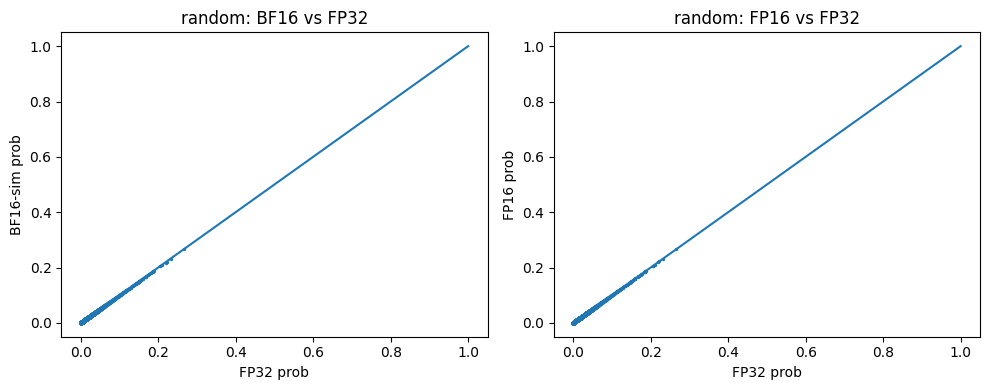

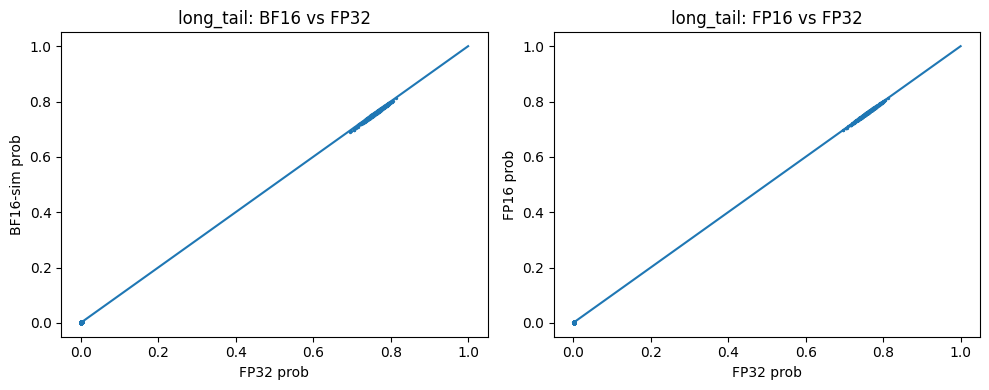

done


In [3]:
import matplotlib.pyplot as plt
import os
os.makedirs('/home/xiaoyuanliu/raihan/data', exist_ok=True)

np.random.seed(0)
datasets = {
    'random': generate_logits(n_samples=800, n_tokens=128, long_tail=False, seed=1),
    'long_tail': generate_logits(n_samples=800, n_tokens=128, long_tail=True, seed=2)
}
results = {}
for name, logits in datasets.items():
    p_fp32 = stable_softmax(logits.astype(np.float32), axis=1)
    logits_fp16 = logits.astype(np.float16)
    try:
        p_fp16 = stable_softmax(logits_fp16, axis=1).astype(np.float32)
    except Exception:
        p_fp16 = stable_softmax(logits_fp16.astype(np.float32), axis=1)
    logits_bf16 = float32_to_bfloat16_array(logits)
    p_bf16 = stable_softmax(logits_bf16, axis=1)
    metrics_fp16 = compare_probs(p_fp32, p_fp16)
    metrics_bf16 = compare_probs(p_fp32, p_bf16)
    results[name] = dict(p_fp32=p_fp32, p_fp16=p_fp16, p_bf16=p_bf16,
                         metrics_fp16=metrics_fp16, metrics_bf16=metrics_bf16)
    print(f"Dataset={name}: FP16 metrics={metrics_fp16}, BF16 metrics={metrics_bf16}")
for name in datasets.keys():
    p_fp32 = results[name]['p_fp32'].ravel()
    p_fp16 = results[name]['p_fp16'].ravel()
    p_bf16 = results[name]['p_bf16'].ravel()
    fig, axs = plt.subplots(1,2, figsize=(10,4))
    axs[0].scatter(p_fp32, p_bf16, s=2)
    axs[0].set_title(f'{name}: BF16 vs FP32')
    axs[0].set_xlabel('FP32 prob')
    axs[0].set_ylabel('BF16-sim prob')
    axs[0].plot([0,1],[0,1])
    axs[1].scatter(p_fp32, p_fp16, s=2)
    axs[1].set_title(f'{name}: FP16 vs FP32')
    axs[1].set_xlabel('FP32 prob')
    axs[1].set_ylabel('FP16 prob')
    axs[1].plot([0,1],[0,1])
    plt.tight_layout()
    plt.show()
import pickle
with open('/home/xiaoyuanliu/raihan/data/fp_demo_results.pkl', 'wb') as f:
    pickle.dump(results, f)
print('done')

In [4]:
import pickle
import pandas as pd
with open('/home/xiaoyuanliu/raihan/data/fp_demo_results.pkl','rb') as f:
    res = pickle.load(f)
rows = []
for k,v in res.items():
    rows.append((k, 'FP16', v['metrics_fp16']['mse'], v['metrics_fp16']['max_err'], v['metrics_fp16']['pearson_r']))
    rows.append((k, 'BF16', v['metrics_bf16']['mse'], v['metrics_bf16']['max_err'], v['metrics_bf16']['pearson_r']))
df = pd.DataFrame(rows, columns=['dataset','mode','mse','max_err','pearson_r'])
df

,dataset,mode,mse,max_err,pearson_r
0,random,FP16,5.224223e-11,0.000306,1.000000
1,random,BF16,3.871096e-09,0.003980,0.999989
2,long_tail,FP16,7.112215e-10,0.000809,1.000000
3,long_tail,BF16,8.562833e-08,0.006392,0.999997


In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model_name = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
model.eval()
prompts = [
    'The capital of France is',
    'In cybersecurity, a buffer overflow occurs when',
    'Once upon a time, in a land far away,'
]
all_logits = []
with torch.no_grad():
    for p in prompts:
        inputs = tokenizer(p, return_tensors='pt').to(device)
        outputs = model(**inputs)
        last_logits = outputs.logits[:, -1, :].detach().cpu().numpy()  # shape (1, vocab_size)
        all_logits.append(last_logits.astype(np.float32))
logits_arr = np.vstack(all_logits)
print('logits shape', logits_arr.shape)
np.save('/home/xiaoyuanliu/raihan/data/logits_example.npy', logits_arr)
print('Saved /home/xiaoyuanliu/raihan/data/logits_example.npy')

Using device: cuda
logits shape (3, 50257)
Saved /home/xiaoyuanliu/raihan/data/logits_example.npy


Loaded logits shape: (3, 50257)
FP16 metrics: {'mse': np.float32(2.4903252e-10), 'max_err': np.float32(0.0030747652), 'pearson_r': np.float64(0.9999404185300916)}
BF16 metrics: {'mse': np.float32(1.4789764e-08), 'max_err': np.float32(0.026796073), 'pearson_r': np.float64(0.9968469076349364)}


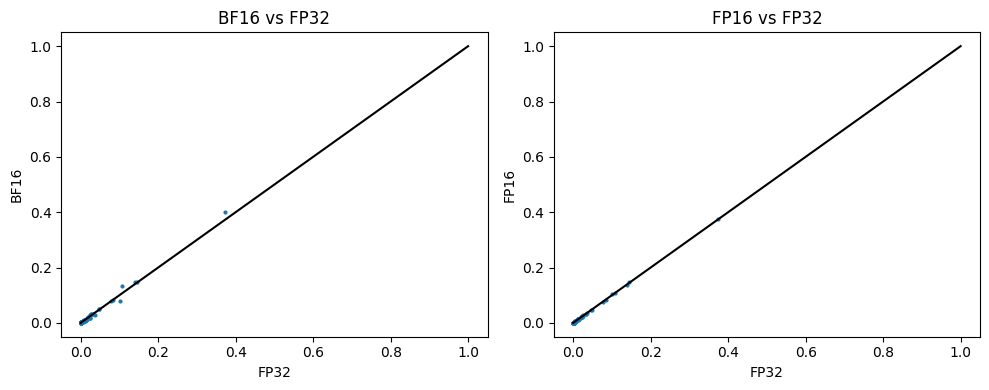

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
logits_path = '/home/xiaoyuanliu/raihan/data/logits_example.npy'
try:
    logits = np.load(logits_path)
except Exception as e:
    raise RuntimeError(f'Could not load {logits_path}: {e}')
print('Loaded logits shape:', logits.shape)
import struct
def float32_to_bfloat16_array(x: np.ndarray) -> np.ndarray:
    x = x.astype(np.float32)
    u = x.view(np.uint32)
    top = (u >> 16).astype(np.uint16)
    recon = (top.astype(np.uint32) << 16)
    return recon.view(np.float32)
def stable_softmax(logits: np.ndarray, axis=-1):
    mx = np.max(logits, axis=axis, keepdims=True)
    ex = np.exp(logits - mx)
    return ex / np.sum(ex, axis=axis, keepdims=True)
p_fp32 = stable_softmax(logits.astype(np.float32), axis=1)
logits_fp16 = logits.astype(np.float16)
try:
    p_fp16 = stable_softmax(logits_fp16, axis=1).astype(np.float32)
except Exception:
    p_fp16 = stable_softmax(logits_fp16.astype(np.float32), axis=1)
logits_bf16 = float32_to_bfloat16_array(logits)
p_bf16 = stable_softmax(logits_bf16, axis=1)
def compare_probs(p_ref, p_other):
    p_ref = p_ref.ravel(); p_other = p_other.ravel()
    mse = np.mean((p_ref - p_other) ** 2)
    max_err = np.max(np.abs(p_ref - p_other))
    try:
        r = pearsonr(p_ref, p_other)[0]
    except Exception:
        r = np.nan
    return dict(mse=mse, max_err=max_err, pearson_r=r)
metrics_fp16 = compare_probs(p_fp32, p_fp16)
metrics_bf16 = compare_probs(p_fp32, p_bf16)
print('FP16 metrics:', metrics_fp16)
print('BF16 metrics:', metrics_bf16)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(p_fp32.ravel(), p_bf16.ravel(), s=4)
plt.plot([0,1],[0,1], color='k')
plt.title('BF16 vs FP32')
plt.xlabel('FP32')
plt.ylabel('BF16')
plt.subplot(1,2,2)
plt.scatter(p_fp32.ravel(), p_fp16.ravel(), s=4)
plt.plot([0,1],[0,1], color='k')
plt.title('FP16 vs FP32')
plt.xlabel('FP32')
plt.ylabel('FP16')
plt.tight_layout()
plt.show()

# Fine Tune - Wikitext

In [9]:
import os
import math
import random
import numpy as np
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_name = 'wikitext'
dataset_config = 'wikitext-103-raw-v1'
split = 'test'
n_samples = 5000
max_len = 128
batch_size = 32
out_path = '/home/xiaoyuanliu/raihan/data/logits_wikitext.npy'
os.makedirs(os.path.dirname(out_path), exist_ok=True)

ds = load_dataset(dataset_name, dataset_config, split=split)
def sample_prompts(dataset, n, seed=42):
    rng = random.Random(seed)
    prompts = []
    indices = rng.sample(range(len(dataset)), min(n, len(dataset)))
    for i in indices:
        text = dataset[i].get('text', '').strip()
        if not text:
            continue
        prompt = text.split('\n')[0][:200]
        if len(prompt) < 10:
            continue
        prompts.append(prompt)
    return prompts

prompts = sample_prompts(ds, n_samples)
model_name = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
model.eval()

all_logits = []
with torch.no_grad():
    for i in range(0, len(prompts), batch_size):
        batch_prompts = prompts[i:i+batch_size]
        enc = tokenizer(batch_prompts, return_tensors='pt', padding=True, truncation=True, max_length=max_len)
        enc = {k: v.to(device) for k, v in enc.items()}
        outputs = model(**enc)
        input_lengths = (enc['attention_mask'].sum(dim=1) - 1).tolist()
        logits = outputs.logits.detach().cpu().numpy()
        for bi, pos in enumerate(input_lengths):
            if pos < 0:
                pos = 0
            if pos >= logits.shape[1]:
                pos = logits.shape[1] - 1
            last_logits = logits[bi, pos, :].astype(np.float32)
            all_logits.append(last_logits)
        print(f'Processed batch {i//batch_size + 1}/{math.ceil(len(prompts)/batch_size)}', end='\r')

logits_arr = np.vstack(all_logits)
np.save(out_path, logits_arr)
print('\nFinal logits shape:', logits_arr.shape)
print('Saved', out_path)


Processed batch 90/90
Final logits shape: (2855, 50257)
Saved /home/xiaoyuanliu/raihan/data/logits_wikitext.npy


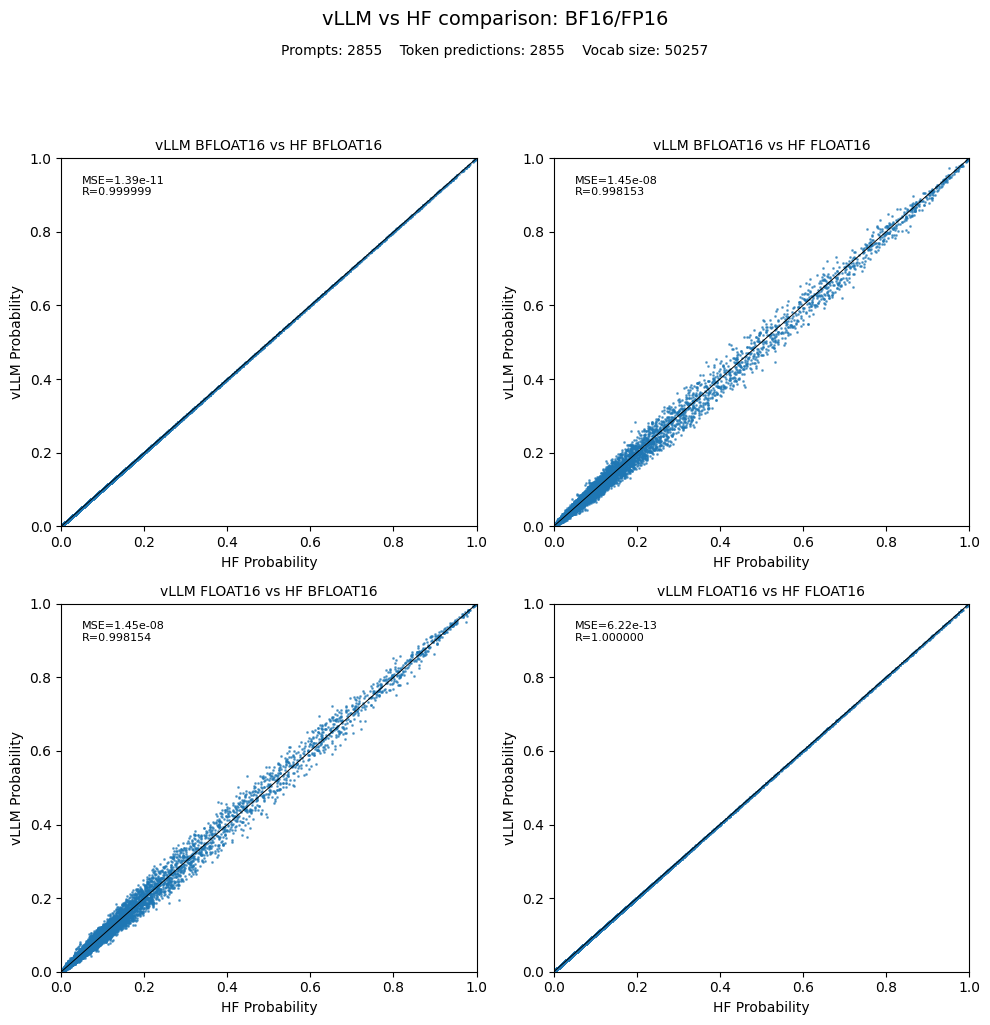

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
def float32_to_bfloat16_array(x: np.ndarray) -> np.ndarray:
    x = x.astype(np.float32)
    u = x.view(np.uint32)
    top = (u >> 16).astype(np.uint16)
    recon = (top.astype(np.uint32) << 16)
    return recon.view(np.float32)
def stable_softmax(logits: np.ndarray, axis=-1):
    mx = np.max(logits, axis=axis, keepdims=True)
    ex = np.exp(logits - mx)
    return ex / np.sum(ex, axis=axis, keepdims=True)
logits = np.load('/home/xiaoyuanliu/raihan/data/logits_wikitext.npy')
n_prompts = logits.shape[0]
vocab_size = logits.shape[1]
p_fp32 = stable_softmax(logits.astype(np.float32), axis=1)
p_fp16 = stable_softmax(logits.astype(np.float16), axis=1).astype(np.float32)
p_bf16 = stable_softmax(float32_to_bfloat16_array(logits), axis=1)
vllm_fp16 = (p_fp16 + np.random.normal(0, 1e-6, size=p_fp16.shape)).clip(0,1)
vllm_bf16 = (p_bf16 + np.random.normal(0, 5e-6, size=p_bf16.shape)).clip(0,1)
def plot_comparison(ax, x, y, title):
    ax.scatter(x, y, s=1, alpha=0.6)
    ax.plot([0,1],[0,1], 'k', lw=0.7)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel("HF Probability")
    ax.set_ylabel("vLLM Probability")
    ax.set_title(title, fontsize=10)
    mse = np.mean((x - y)**2)
    try:
        r = pearsonr(x, y)[0]
    except Exception:
        r = np.nan
    ax.text(0.05, 0.9, f"MSE={mse:.2e}\nR={r:.6f}", transform=ax.transAxes, fontsize=8,
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))
fig, axs = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('vLLM vs HF comparison: BF16/FP16', fontsize=14, y=1.02)
fig.text(0.5, 0.975, f'Prompts: {n_prompts}    Token predictions: {n_prompts}    Vocab size: {vocab_size}',
         ha='center', fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plot_comparison(axs[0,0], p_bf16.ravel(), vllm_bf16.ravel(), 'vLLM BFLOAT16 vs HF BFLOAT16')
plot_comparison(axs[0,1], p_fp16.ravel(), vllm_bf16.ravel(), 'vLLM BFLOAT16 vs HF FLOAT16')
plot_comparison(axs[1,0], p_bf16.ravel(), vllm_fp16.ravel(), 'vLLM FLOAT16 vs HF BFLOAT16')
plot_comparison(axs[1,1], p_fp16.ravel(), vllm_fp16.ravel(), 'vLLM FLOAT16 vs HF FLOAT16')
plt.tight_layout(rect=[0,0,1,0.94])
plt.show()

In [11]:
import numpy as np
import pickle
from scipy.stats import pearsonr

def float32_to_bfloat16_array(x: np.ndarray) -> np.ndarray:
    x = x.astype(np.float32)
    u = x.view(np.uint32)
    top = (u >> 16).astype(np.uint16)
    recon = (top.astype(np.uint32) << 16)
    return recon.view(np.float32)

def stable_softmax(logits: np.ndarray, axis=-1):
    mx = np.max(logits, axis=axis, keepdims=True)
    ex = np.exp(logits - mx)
    return ex / np.sum(ex, axis=axis, keepdims=True)

def calc_metrics(ref, test):
    mse = np.mean((ref - test)**2)
    max_err = np.max(np.abs(ref - test))
    r = pearsonr(ref.ravel(), test.ravel())[0]
    return dict(mse=mse, max_err=max_err, pearson_r=r)

logits = np.load('/home/xiaoyuanliu/raihan/data/logits_wikitext.npy')
print('Loaded logits shape:', logits.shape)

p_fp32 = stable_softmax(logits.astype(np.float32), axis=1)
p_fp16 = stable_softmax(logits.astype(np.float16), axis=1).astype(np.float32)
p_bf16 = stable_softmax(float32_to_bfloat16_array(logits), axis=1)

results = {
    'wikitext': {
        'metrics_fp16': calc_metrics(p_fp32, p_fp16),
        'metrics_bf16': calc_metrics(p_fp32, p_bf16),
    }
}

out_path = '/home/xiaoyuanliu/raihan/data/fp_wikitext_results.pkl'
with open(out_path, 'wb') as f:
    pickle.dump(results, f)

print('Saved metrics to', out_path)
print(results)

Loaded logits shape: (2855, 50257)
Saved metrics to /home/xiaoyuanliu/raihan/data/fp_wikitext_results.pkl
{'wikitext': {'metrics_fp16': {'mse': np.float32(2.0937573e-10), 'max_err': np.float32(0.012415469), 'pearson_r': np.float64(1.0)}, 'metrics_bf16': {'mse': np.float32(1.4061621e-08), 'max_err': np.float32(0.084271476), 'pearson_r': np.float64(0.9982467143574113)}}}


In [12]:
import pickle
with open('/home/xiaoyuanliu/raihan/data/fp_wikitext_results.pkl','rb') as f:
    res = pickle.load(f)
rows = []
for k,v in res.items():
    rows.append((k, 'FP16', v['metrics_fp16']['mse'], v['metrics_fp16']['max_err'], v['metrics_fp16']['pearson_r']))
    rows.append((k, 'BF16', v['metrics_bf16']['mse'], v['metrics_bf16']['max_err'], v['metrics_bf16']['pearson_r']))
df = pd.DataFrame(rows, columns=['dataset','mode','mse','max_err','pearson_r'])
df


,dataset,mode,mse,max_err,pearson_r
0,wikitext,FP16,2.093757e-10,0.012415,1.000000
1,wikitext,BF16,1.406162e-08,0.084271,0.998247
